# The Nurses Model

This tutorial includes everything you need to set up IBM Decision Optimization CPLEX Modeling for Python (DOcplex), build a Mathematical Programming model, and get its solution by solving the model on the cloud with IBM ILOG CPLEX Optimizer.

When you finish this tutorial, you'll have a foundational knowledge of _Prescriptive Analytics_.

>This notebook is part of [Prescriptive Analytics for Python](http://ibmdecisionoptimization.github.io/docplex-doc/)
>
>It requires either an [installation of CPLEX Optimizers](http://ibmdecisionoptimization.github.io/docplex-doc/getting_started.html) or it can be run on [IBM Watson Studio Cloud](https://www.ibm.com/cloud/watson-studio/>) (Sign up for a [free IBM Cloud account](https://dataplatform.cloud.ibm.com/registration/stepone?context=wdp&apps=all>)
and you can start using Watson Studio Cloud right away).


Table of contents:

-  [Describe the business problem](#Describe-the-business-problem)
*  [How decision optimization (prescriptive analytics) can help](#How--decision-optimization-can-help)
*  [Use decision optimization](#Use-decision-optimization)
    *  [Step 1: Import the library](#Step-1:-Import-the-library)
    -  [Step 2: Model the data](#Step-2:-Model-the-data)
    *  [Step 3: Prepare the data](#Step-3:-Prepare-the-data)
    -  [Step 4: Set up the prescriptive model](#Step-4:-Set-up-the-prescriptive-model)
        * [Define the decision variables](#Define-the-decision-variables)
        * [Express the business constraints](#Express-the-business-constraints)
        * [Express the objective](#Express-the-objective)
        * [Solve with Decision Optimization](#Solve-with-Decision-Optimization)
    *  [Step 5: Investigate the solution and run an example analysis](#Step-5:-Investigate-the-solution-and-then-run-an-example-analysis)
*  [Summary](#Summary)

****

## Describe the business problem

This model deals with nurse scheduling. Nurses must be assigned to hospital shifts in accordance with various skill and staffing constraints.

The goal of the model is to find an efficient balance between the different objectives:

* minimize the overall cost of the plan and
* assign shifts as fairly as possible.


## How  decision optimization can help

* Prescriptive analytics (decision optimization) technology recommends actions that are based on desired outcomes.  It takes into account specific scenarios, resources, and knowledge of past and current events. With this insight, your organization can make better decisions and have greater control of business outcomes.  

* Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

* Prescriptive analytics takes that insight to the next level by suggesting the optimal way to handle that future situation. Organizations that can act fast in dynamic conditions and make superior decisions in uncertain environments gain a strong competitive advantage.  
<br/>

<u>With prescriptive analytics, you can:</u> 

* Automate the complex decisions and trade-offs to better manage your limited resources.
* Take advantage of a future opportunity or mitigate a future risk.
* Proactively update recommendations based on changing events.
* Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.

## Use decision optimization

### Step 1: Import the library

Run the following code to import Decision Optimization CPLEX Modeling library.  The *DOcplex* library contains the two modeling packages, Mathematical Programming and Constraint Programming.

In [1]:
import sys
try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')

### Step 2: Model the data

Input data consists of several tables:

* The Departments table lists all departments in the scope of the assignment.
* The Skills table list all skills.
* The Shifts table lists all shifts to be staffed. A shift contains a department, a day in the week, plus the start and end times.
* The Nurses table lists all nurses, identified by their names.
* The NurseSkills table gives the skills of each nurse.
* The SkillRequirements table lists the minimum number of persons required for a given department and skill.
* The NurseVacations table lists days off for each nurse.
* The NurseAssociations table lists pairs of nurses who wish to work together.
* The NurseIncompatibilities table lists pairs of nurses who do not want to work together
.
In addition, the plan has to satisfy a maximum worktime for all nurses, for example 40 hours a week.

### Step 3: Prepare the data

Now we need some basic data structures to store information.

In [2]:
from enum import Enum
from collections import namedtuple

# utility to conevrt a weekday string to an index in 0..6
_all_days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]


def day_to_day_week(day):
    day_map = {day: d for d, day in enumerate(_all_days)}
    return day_map[day.lower()]

TWorkRules = namedtuple("TWorkRules", ["work_time_max"])
TVacation = namedtuple("TVacation", ["nurse", "day"])
TNursePair = namedtuple("TNursePair", ["firstNurse", "secondNurse"])
TNurseSkill = namedtuple("TNurseSkill", ["nurse", "skill"])
TSkillRequirement = namedtuple("TSkillRequirement", ["department", "skill", "required"])


# subclass the namedtuple to refine the str() method as the nurse's name
class TNurse(namedtuple("TNurse1", ["name", "pay_rate"])):
    """ A subclass to redefine the default str() of namedtuple.
    This class is used in variable naming, so we need to redefine the str() method
    used by variable naming.
    """

    def __str__(self):
        return self.name


class TShift(
    namedtuple("TShift1", ["department", "day", "start_time", "end_time", "min_requirement", "max_requirement"])):
    """ specialize namedtuple to redefine its str() method
    """

    def __str__(self):
        # keep first two characters in departement, uppercased
        dept2 = self.department[0:4].upper()
        # keep 3 days of weekday
        dayname = self.day[0:3]
        return '%s_%s_%02d' % (dept2, dayname, self.start_time)
    

class ShiftActivity(object):
    @staticmethod
    def to_abstime(day_index, time_of_day):
        """ Convert a pair (day_index, time) into a number of hours since Monday 00:00

        :param day_index: The index of the day from 1 to 7 (Monday is 1).
        :param time_of_day: An integer number of hours.

        :return:
        """
        time = 24 * (day_index - 1)
        time += time_of_day
        return time

    def __init__(self, weekday, start_time_of_day, end_time_of_day):
        assert (start_time_of_day >= 0)
        assert (start_time_of_day <= 24)
        assert (end_time_of_day >= 0)
        assert (end_time_of_day <= 24)

        self._weekday = weekday
        self._start_time_of_day = start_time_of_day
        self._end_time_of_day = end_time_of_day
        # conversion to absolute time.
        start_day_index = day_to_day_week(self._weekday)
        self.start_time = self.to_abstime(start_day_index, start_time_of_day)
        self.day_start_time = self.to_abstime(start_day_index, 0)
        end_day_index = start_day_index if end_time_of_day > start_time_of_day else start_day_index + 1
        self.end_time = self.to_abstime(end_day_index, end_time_of_day)
        assert self.end_time > self.start_time

    @property
    def duration(self):
        return self.end_time - self.start_time

    def overlaps(self, other_shift):
        if not isinstance(other_shift, ShiftActivity):
            return False
        else:
            return other_shift.end_time > self.start_time and other_shift.start_time < self.end_time


#### Loading data from Excel with pandas

We load the data from an Excel file using *pandas*.
Each sheet is read into a separate *pandas* DataFrame.

In [3]:
CSS = """
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}
    table.dataframe thead th:first-child {
        display: none;
    }
    table.dataframe tbody th {
        display: none;
    }
"""

In [4]:
from IPython.core.display import HTML
HTML('<style>{}</style>'.format(CSS))

from IPython.display import display

In [5]:
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

In [6]:
# This notebook requires pandas to work
import pandas as pd

# Make sure that xlrd package, which is a pandas optional dependency, is installed
# This package is required for Excel I/O
try:
    import xlrd
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install xlrd 
    else:
        !pip install --user xlrd  
        
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen

data_url = "https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/mp/jupyter/nurses_data.xls?raw=true"
nurse_xls_file = pd.ExcelFile(urlopen(data_url))

SkillTable = nurse_xls_file.parse('Skills')
DeptTable  = nurse_xls_file.parse('Departments')
ShiftTable = nurse_xls_file.parse('Shifts')
SkillRequirementTable = nurse_xls_file.parse('SkillRequirements')
NurseTable = nurse_xls_file.parse('Nurses')
NurseSkillTable = nurse_xls_file.parse('NurseSkills')
NurseVacationTable = nurse_xls_file.parse('NurseVacations')
NurseAssociationTable = nurse_xls_file.parse('NurseAssociations')
NurseIncompatibilityTable = nurse_xls_file.parse('NurseIncompatibilities')

display(NurseTable)

,name,seniority,qualification,pay_rate
0,Anne,11,1,25
1,Bethanie,4,5,28
2,Betsy,2,2,17
3,Cathy,2,2,17
4,Cecilia,9,5,38
5,Chris,11,4,38
6,Cindy,5,2,21
7,David,1,2,15
8,Debbie,7,2,24
9,Dee,3,3,21


Now, we create some additional data structures to be used for building the prescriptive model.<br>
The goal is to not depend on *pandas* when defining decision variables and constraints.
The 'nurses_pandas' notebook illustrates how to benefit from pandas to build the prescriptive model.

In [7]:
skills = [SkillTable["name"][i] for i in range(len(SkillTable))]
depts  = [DeptTable["name"][i] for i in range(len(DeptTable))]
nurses =[TNurse(NurseTable["name"][i], NurseTable["pay_rate"][i]) for i in range(len(NurseTable))]

nurses = [nurse for nurse in nurses if nurse.pay_rate <25 and nurse.pay_rate >15]
# Build {nurse: [skills]} dictionary
nurse_skills = {}
for nsk in NurseSkillTable.itertuples(index=False):
    nskt= TNurseSkill(*nsk)
    nurse_skills.setdefault(nskt.nurse, []).append(nskt.skill)

shifts = [TShift(*shift_row) for shift_row in ShiftTable.itertuples(index=False)]
skill_requirements = [TSkillRequirement(*skill_requirement_row) for skill_requirement_row in
                      SkillRequirementTable.itertuples(index=False)]
vacations = [TVacation(*vacation_row) for vacation_row in NurseVacationTable.itertuples(index=False)]
nurse_associations = [TNursePair(*na) for na in NurseAssociationTable.itertuples(index=False)]
nurse_incompatibilities = [TNursePair(*na) for na in NurseIncompatibilityTable.itertuples(index=False)]

# compute shift activities (start, end, duration) and store them in a dict indexed by shifts
shift_activities = {s: ShiftActivity(s.day, s.start_time, s.end_time) for s in shifts}

# map from nurse names to nurse tuples.
nurses_by_id = {n.name: n for n in nurses}

# Work rules: max work time
work_rules = TWorkRules(40)

### Step 4: Set up the prescriptive model

In [8]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Windows 64bit
* Python version 3.6.8, located at: C:\python\anaconda531\envs\531_36\python.exe
* docplex is present, version is (2, 10, 0)
* CPLEX library is present, version is 12.9.0.0, located at: C:\OPTIM\python\cplex1290R1\3.6\x64_win64
* pandas is present, version is 0.23.4


#### Create the DOcplex model
This model contains all the business constraints and defines the objective.

In [9]:
from docplex.mp.model import Model

mdl = Model("nurses")

#### Define the decision variables

The basic decisions are "which nurse works which shift", which is modeled by binary variables for each (nurse, shift) pair.

The output of the model is, for each shift, the list of nurses that work the shift.



In [10]:
# One binary variable for each pair (nurse, shift) equal to 1 if nurse n is assigned to shift s
nurse_assignment_vars = mdl.binary_var_matrix(nurses, shifts, 'NurseAssigned')

# For each nurse, allocate one variable for worktime
nurse_work_time_vars = mdl.continuous_var_dict(nurses, lb=0, name='NurseWorkTime')

# And two variables for over_average and under-average work time
nurse_over_average_time_vars = mdl.continuous_var_dict(nurses, lb=0, name='NurseOverAverageWorkTime')
nurse_under_average_time_vars = mdl.continuous_var_dict(nurses, lb=0, name='NurseUnderAverageWorkTime')

# Finally the global average work time
average_nurse_work_time = mdl.continuous_var(lb=0, name='AverageWorkTime')

#### Express the business constraints
##### First constraint: define average work time
The average work time over all nurses will be used in particular to calculate the over/under average work time for each nurse, and to formulate a _fairness_ rule.

In [11]:
mdl.add_constraint(len(nurses) * average_nurse_work_time ==
                   mdl.sum(nurse_work_time_vars[n] for n in nurses), "average")

docplex.mp.LinearConstraint[average](18AverageWorkTime,EQ,NurseWorkTime_Betsy+NurseWorkTime_Cathy+NurseWorkTime_Cindy+NurseWorkTime_Debbie+NurseWorkTime_Dee+NurseWorkTime_Isabelle+NurseWorkTime_Jane+NurseWorkTime_Janelle+NurseWorkTime_Janice+NurseWorkTime_Jemma+NurseWorkTime_Joan+NurseWorkTime_Jude+NurseWorkTime_Julie+NurseWorkTime_Kate+NurseWorkTime_Patrick+NurseWorkTime_Suzanne+NurseWorkTime_Vickie+NurseWorkTime_Wendie)

##### Second constraint: compute nurse work time, average and under/over time

In [12]:
for n in nurses:
    work_time_var = nurse_work_time_vars[n]
    mdl.add_constraint(
        work_time_var == mdl.sum(nurse_assignment_vars[n, s] * shift_activities[s].duration for s in shifts),
        "work_time_{0!s}".format(n))

    # Relate over/under average worktime variables to the worktime variables.
    # The trick here is that variables have zero lower bound
    # however, these variables are not completely defined by this constraint,
    # only their difference is.
    # If these variables are part of the objective, CPLEX will naturally minimize their value,
    # as expected.
    mdl.add_constraint(
        work_time_var == average_nurse_work_time + nurse_over_average_time_vars[n] - nurse_under_average_time_vars[n],
        "average_work_time_{0!s}".format(n))

    # State the maximum work time as a constraint, so that it can be relaxed,
    # should the problem become infeasible.
    mdl.add_constraint(work_time_var <= work_rules.work_time_max, "max_time_{0!s}".format(n))

##### Third constraint: vacations
When a nurse is on vacation, he or she cannot be assigned to any shift starting that day.

In [13]:
for vac_nurse_id, vac_day in vacations:
        vac_n = nurses_by_id.get(vac_nurse_id, -1)
        if vac_n != -1:
            for shift in (s for s in shifts if s.day == vac_day):
                mdl.add_constraint(nurse_assignment_vars[vac_n, shift] == 0,
                                     "medium_vacations_{0!s}_{1!s}_{2!s}".format(vac_n, vac_day, shift))

##### Fourth constraint: a nurse cannot be assigned overlapping shifts
Some shifts overlap in time and thus cannot be assigned to the same nurse.

In [14]:
# Post only one constraint per couple(s1, s2)
number_of_overlaps = 0
nb_shifts = len(shifts)
for i1 in range(nb_shifts):
    for i2 in range(i1 + 1, nb_shifts):
        s1 = shifts[i1]
        s2 = shifts[i2]
        if shift_activities[s1].overlaps(shift_activities[s2]):
            number_of_overlaps += 1
            for n in nurses:
                mdl.add_constraint(nurse_assignment_vars[n, s1] + nurse_assignment_vars[n, s2] <= 1,
                                   "high_overlapping_{0!s}_{1!s}_{2!s}".format(s1, s2, n))
print("# overlapping shifts: {}".format(number_of_overlaps))

# overlapping shifts: 20


##### Fifth constraint: enforce minimum and maximum requirements for shifts
Each shift requires a minimum and a maximum number of nurses. 
For each shift, the sum over all nurses of assignments to this shift
must be greater than or equal to the minimum requirement and lesser than or equal to the maximum requirement.

In [15]:
for s in shifts:
    demand_min = s.min_requirement
    demand_max = s.max_requirement
    total_assigned = mdl.sum(nurse_assignment_vars[n, s] for n in nurses)
    mdl.add_constraint(total_assigned >= demand_min,
                       "high_req_min_{0!s}_{1}".format(s, demand_min))
    mdl.add_constraint(total_assigned <= demand_max,
                       "medium_req_max_{0!s}_{1}".format(s, demand_max))

##### Sixth constraint: enforce skill requirements for selected shifts
Some shifts require at least _x_ nurses with a specified skill.

In [16]:
for (dept, skill, required) in skill_requirements:
    if required > 0:
        for dsh in (s for s in shifts if dept == s.department):
            mdl.add_constraint(mdl.sum(nurse_assignment_vars[skilled_nurse, dsh] for skilled_nurse in
                                       (n for n in nurses if n.name in nurse_skills.keys() and 
                                        skill in nurse_skills[n.name])) >= required,
                               "high_required_{0!s}_{1!s}_{2!s}_{3!s}".format(dept, skill, required, dsh))

##### Seventh constraint: associations
Some pairs of nurses get along particularly well, so we wish to assign them together as a team. In other words, for every such pair and for each shift, both assignment variables should always be equal.
Either both nurses work the shift, or both do not.

In [17]:
# for each pair of associted nurses, their assignement variables are equal over all shifts.
c = 0
for (nurse_id1, nurse_id2) in nurse_associations:
    if nurse_id1 in nurses_by_id and nurse_id2 in nurses_by_id:
        nurse1 = nurses_by_id[nurse_id1]
        nurse2 = nurses_by_id[nurse_id2]
        for s in shifts:
            c += 1
            ctname = 'medium_ct_nurse_assoc_{0!s}_{1!s}_{2:d}'.format(nurse_id1, nurse_id2, c)
            mdl.add_constraint(nurse_assignment_vars[nurse1, s] == nurse_assignment_vars[nurse2, s], ctname)

##### Eighth constraint: incompatibilities
Similarly, certain pairs of nurses do not get along well, and we want to avoid having them together on a shift.<br>
In other words, for each shift, both nurses of an incompatible pair cannot be assigned together to the shift.

In [18]:
# For each pair of incompatible nurses, the sum of assigned variables is less than one
c = 0
for (nurse_id1, nurse_id2) in nurse_incompatibilities:
    if nurse_id1 in nurses_by_id and nurse_id2 in nurses_by_id:
        nurse1 = nurses_by_id[nurse_id1]
        nurse2 = nurses_by_id[nurse_id2]
        for s in shifts:
            c += 1
            ctname = 'medium_ct_nurse_incompat_{0!s}_{1!s}_{2:d}'.format(nurse_id1, nurse_id2, c)
            mdl.add_constraint(nurse_assignment_vars[nurse1, s] + nurse_assignment_vars[nurse2, s] <= 1, ctname)

#### Express the objective
The objective mixes different (and contradictory) KPIs. 

The first KPI is the total salary cost, computed as the sum of work times over all nurses, weighted by pay rate.<br>
The second KPI is the total number of assignments (nurse, shift).<br>
The third KPI is the average total work time over all nurses.<br>
The fourth KPI represents the total number of hours that is above the average work time (summed over all nurses), while the fifth KPI represents the total number of hours that is below this average.
<br>
Finally, the last KPI is a measure of fairness, which is evaluated as the total deviation from the average work time.

In [19]:
total_number_of_assignments = mdl.sum(nurse_assignment_vars[n,s] for n in nurses for s in shifts)
nurse_costs = [nurse_assignment_vars[n, s] * n.pay_rate * shift_activities[s].duration for n in nurses for s in shifts]
total_salary_cost = mdl.sum(nurse_costs)
mdl.add_kpi(total_salary_cost, "Total salary cost")
mdl.add_kpi(total_number_of_assignments, "Total number of assignments")
mdl.add_kpi(average_nurse_work_time)

total_over_average_worktime = mdl.sum(nurse_over_average_time_vars[n] for n in nurses)
total_under_average_worktime = mdl.sum(nurse_under_average_time_vars[n] for n in nurses)
mdl.add_kpi(total_over_average_worktime, "Total over-average worktime")
mdl.add_kpi(total_under_average_worktime, "Total under-average worktime")

total_fairness = total_over_average_worktime + total_under_average_worktime
mdl.add_kpi(total_fairness, "Total fairness")

mdl.print_information()

Model: nurses
 - number of variables: 793
   - binary=738, integer=0, continuous=55
 - number of constraints: 961
   - linear=961
 - parameters: defaults
 - problem type is: MILP


##### Minimizing objective
The goal is to minimize the non-weighted sum of the _total salary cost_, _fairness_ and _total number of assignment_.<br>
This is accomplished using the `Model.minimize()` method.<br>

This definition is arbitrary and could be revised. For instance, one could emphasize minimizing salary cost by adding a weight on this term in the objective.

In [20]:
mdl.minimize(total_salary_cost + total_fairness + total_number_of_assignments)

#### Solve with Decision Optimization
Now we have everything we need to solve the model, using `Model.solve()`. The following cell solves using your local CPLEX (if any, and provided you have added it to your `PYTHONPATH` variable). 


In [21]:
# Set Cplex mipgap to 1e-5 to enforce precision to be of the order of a unit (objective value magnitude is ~1e+5).
mdl.parameters.mip.tolerances.mipgap = 1e-5

s = mdl.solve(log_output=True)
if not s:
    # solve has failed, we try relaxation, based on constraint names
    # constraints are prioritized according to their names
    # if a name contains "low", it has priority LOW
    # if a ct name contains "medium" it has priority MEDIUM
    # same for HIGH
    # if a constraint has no name or does not match any, it is not relaxable.
    from docplex.mp.relaxer import Relaxer
    relaxer = Relaxer(prioritizer='match', verbose=True)
    # self.enable_trace()
    #self.parameters.mip.tolerances.mipgap = 0.03 # 3%
    relaxed_sol = relaxer.relax(mdl)
    relaxed_ok = relaxed_sol is not None
    assert relaxed_ok, "relaxation failed"
    relaxer.print_information()

mdl.report()

CPXPARAM_Read_DataCheck                          1
CPXPARAM_MIP_Tolerances_MIPGap                   1.0000000000000001e-05
Bound infeasibility column 'NurseWorkTime_Betsy'.
Presolve time = 0.00 sec. (0.29 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.45 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.45 ticks)
* number of relaxations: 35
 - relaxed: high_req_min_EMER_Mon_08_4, with relaxation: -2.0
 - relaxed: high_req_min_EMER_Mon_18_3, with relaxation: -3.0
 - relaxed: high_req_min_CONS_Mon_08_10, with relaxation: -5.0
 - relaxed: high_req_min_CONS_Mon_12_8, with relaxation: -4.0
 - relaxed: high_req_min_CARD_Mon_08_10, with relaxation: -4.0
 - relaxed: high_req_min_CARD_Mon_12_8, with relaxation: -5.0
 - relaxed: high_req_min_EMER_Tue_08_4, with relaxat

### Step 5: Investigate the solution and then run an example analysis

Let's display some charts to visualize the results: a Gantt chart displaying the assignment of nurses to shifts in a Gantt chart, and another chart showing the number of assigned nurses to each department over time.

In [22]:
min(shift_activities, key=lambda i: shift_activities[i].day_start_time)
min(s.day_start_time for s in shift_activities.values())

-24

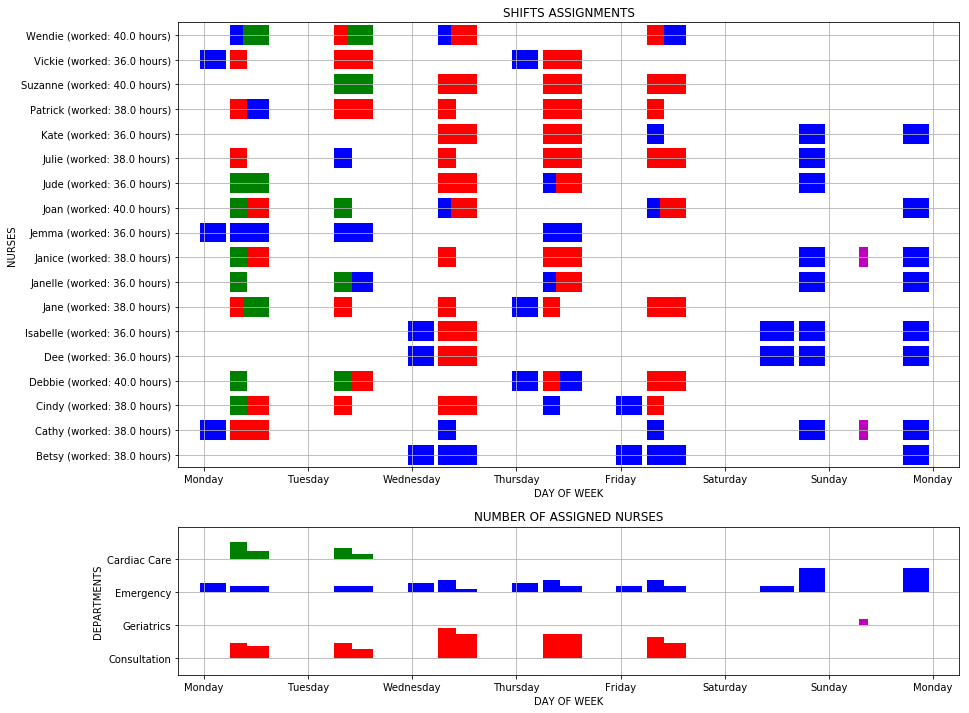

In [23]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Build set of all departments and assign a color to each of them to be used in figures
departments = {s.department for s in shifts}
colorByDepartment = {}
for d, c in zip(departments, ['r', 'm', 'b', 'g', 'y', 'c', 'k']):
    colorByDepartment[d] = c

# Build dictionary with number of assigned nurses for each shift
nbAssignmentsByShift={}
for n in nurses:
    for s in shifts:
        if nurse_assignment_vars[n,s].solution_value > 0:
            nbAssignmentsByShift[s] = nbAssignmentsByShift.get(s,0) + 1

# Build a dictionary with the list of each shift corresponding to each department
shiftsByDepartment = {}
for s in shifts:
    shiftsByDepartment.setdefault(s.department, []).append(s)


# Shared code
def createLabels(ax, title, xlabel, ylabel):
    shiftInfoByDay = {s1.day : s1 for s1 in shifts}
    try: # Python 2
        plt.xticks([shift_activities[s].day_start_time + w * 7 * 24 for w in [0,1] for (d, s) in shiftInfoByDay.iteritems()],
              ["{}".format(s.day) for w in [0,1] for (d, s) in shiftInfoByDay.iteritems()])
    except:
        plt.xticks([shift_activities[s].day_start_time + w * 7 * 24 for w in [0,1] for (d, s) in shiftInfoByDay.items()],
              ["{}".format(s.day) for w in [0,1] for (d, s) in shiftInfoByDay.items()])

    plt.xlim([min(s.day_start_time for s in shift_activities.values()) - 6,
              max(s.day_start_time for s in shift_activities.values()) + 30])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.set_title(title)

# Plot shift assignments for each nurse
def displayNursesAssignmentsGantt(ax):
    ylabels, tickloc = [], []
    for i, n in enumerate(nurses):
        for s in shifts:
            if nurse_assignment_vars[n,s].solution_value > 0:
                shift_activity = shift_activities[s]
                ax.bar(shift_activity.start_time, 0.8,
                       width=shift_activity.end_time - shift_activity.start_time, bottom=i + 0.1,
                       color=colorByDepartment[s.department])

        ylabels.append("{} (worked: {} hours)".format(str(n), nurse_work_time_vars[n].solution_value))
        tickloc.append(i + 0.5)

    plt.ylim(0, len(nurses))
    plt.yticks(tickloc, ylabels)

    # Create labels on x/y axis
    createLabels(ax, 'SHIFTS ASSIGNMENTS', 'DAY OF WEEK', 'NURSES')

# Plot number of assigned nurses for each shift, by department
def displayDepartmentsAssignments(ax):
    ylabels, tickloc = [], []
    maxNbAssignements = max(nbAssignmentsByShift.values())
    for i, d in enumerate(departments):
        for s in shiftsByDepartment[d]:
            shift_activity = shift_activities[s]
            ax.bar(shift_activity.start_time, nbAssignmentsByShift.get(s, 0) / float(maxNbAssignements + 1),
                   width=shift_activity.end_time - shift_activity.start_time, bottom=i + 0.5,
                   color=colorByDepartment[s.department])
        ylabels.append("{}".format(d))
        tickloc.append(i + 0.5)

    plt.ylim(0, len(departments) + 0.5)
    plt.yticks(tickloc, ylabels)

    # Create labels on x/y axis
    createLabels(ax, 'NUMBER OF ASSIGNED NURSES', 'DAY OF WEEK', 'DEPARTMENTS')

# Display figures as two sub-plots so that they are vertically aligned
fig = plt.figure(figsize=[14,12])
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])

ax = plt.subplot(gs[0])
displayNursesAssignmentsGantt(ax)

ax = plt.subplot(gs[1])
displayDepartmentsAssignments(ax)

## Summary

You learned how to set up and use IBM Decision Optimization CPLEX Modeling for Python to formulate a Mathematical Programming model and solve it with IBM Decision Optimization on Cloud.

## References
* [CPLEX Modeling for Python documentation](http://ibmdecisionoptimization.github.io/docplex-doc/)
* [Decision Optimization on Cloud](https://developer.ibm.com/docloud/)
* Need help with DOcplex or to report a bug? Please go [here](https://stackoverflow.com/questions/tagged/docplex).
* Contact us at dofeedback@wwpdl.vnet.ibm.com.

Copyright &copy; 2017-2019 IBM. IPLA licensed Sample Materials.